In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import numpy as np
from data_gen import get_agent_distribution_and_losses_nels
import itertools

In [2]:
def get_final_beta(df, method):
    l = [float(x) for x in list(df[df["method"]==method]["final_beta"].item()[1:-1].split(","))]
    arr = np.array(l).reshape(len(l), 1)
    return arr

# def get_final_beta_spaces(df, method):
#     list2d = [x.split(" ") for x in df[df["method"]=="ewm"]["final_beta"].item()[1:-1].split("  ")]
#     list2 = list(itertools.chain.from_iterable(list2d))
#     nums = []
#     for word in list2:
#         if len(word) != 0:
#             num = float(word)
#             nums.append(num)
#     arr = np.array(nums).reshape(len(nums), 1)
#     return arr

def get_score_distribution(agent_dist, beta, sigma, q):
    s_eq = agent_dist.quantile_fixed_point_true_distribution(beta, sigma, q)
    scores = agent_dist.best_response_noisy_score_distribution(beta, s_eq, sigma)
    return scores

def get_socio_econ(agent_dist):
    socio_econ = 1/np.array([gamma[0].item() for gamma in agent_dist.types["gammas"]])
    n_socio_econ = socio_econ[agent_dist.n_agent_types]
    normalized_socio_econ = (socio_econ- min(socio_econ))/(max(socio_econ)-min(socio_econ))
    return n_socio_econ, normalized_socio_econ

def get_accepted_scores_by_type(agent_dist, agent_type, scores, cutoff):
    type_indicator = agent_dist.n_agent_types == agent_type
    return scores[type_indicator]

In [3]:
beta_bar = np.ones(9)/np.sqrt(9)
agent_dist, all_types_and_losses, all_labels, _, _, sigma = get_agent_distribution_and_losses_nels(n=5000, n_clusters=8,
                                                                                              prev_beta=beta_bar, 
                                                                                              seed=0)
q=0.7

df = pd.read_csv("results/nels_etas_11-26-22.csv")
df = df[df["seed"] == 0]
beta_pe = get_final_beta(df, "total_deriv")
beta_me = get_final_beta(df, "partial_deriv_loss_beta")
beta_naive = get_final_beta(df, "ewm")

In [4]:
beta_naive

array([[ 0.09446925],
       [-0.06267703],
       [-0.08254089],
       [ 0.04580528],
       [ 0.68957755],
       [-0.22385456],
       [ 0.16048543],
       [-0.6496907 ],
       [ 0.06895209]])

In [5]:
beta_pe

array([[ 4.92869107e-01],
       [ 5.06066300e-01],
       [ 5.08498646e-01],
       [ 4.83488714e-01],
       [-3.63596956e-02],
       [ 1.97945841e-04],
       [-3.93446127e-02],
       [-7.01103643e-02],
       [-2.93122011e-02]])

In [6]:
beta_me

array([[0.40042723],
       [0.42516461],
       [0.41605784],
       [0.42730597],
       [0.24393301],
       [0.23825184],
       [0.23282741],
       [0.24414734],
       [0.27039747]])

In [7]:
def plot_score_dist(ax, agent_dist, beta, sigma, q, title):
    scores = get_score_distribution(agent_dist, beta, sigma, q)
    n_socio_econ, normalized_socio_econ = get_socio_econ(agent_dist)
    colormap = cm.get_cmap('coolwarm', 8)
    colormap = colormap(normalized_socio_econ)
    cutoff = np.quantile(scores, q)
    ax.axvline(x=cutoff, c="black", label="Threshold")

    for i in range(agent_dist.n_types):
        ax.hist(get_accepted_scores_by_type(agent_dist, i, scores, cutoff), alpha=0.7, color=colormap[i])
    ax.set_title(title, fontsize=20)
    ax.legend(fontsize=18)
    #ax.set_xlim(1, 26)
    ax.set_ylim(1, 250)
    ax.set_xlabel("Scores", fontsize=20)
    ax.set_ylabel("Count", fontsize=20)
    return normalized_socio_econ

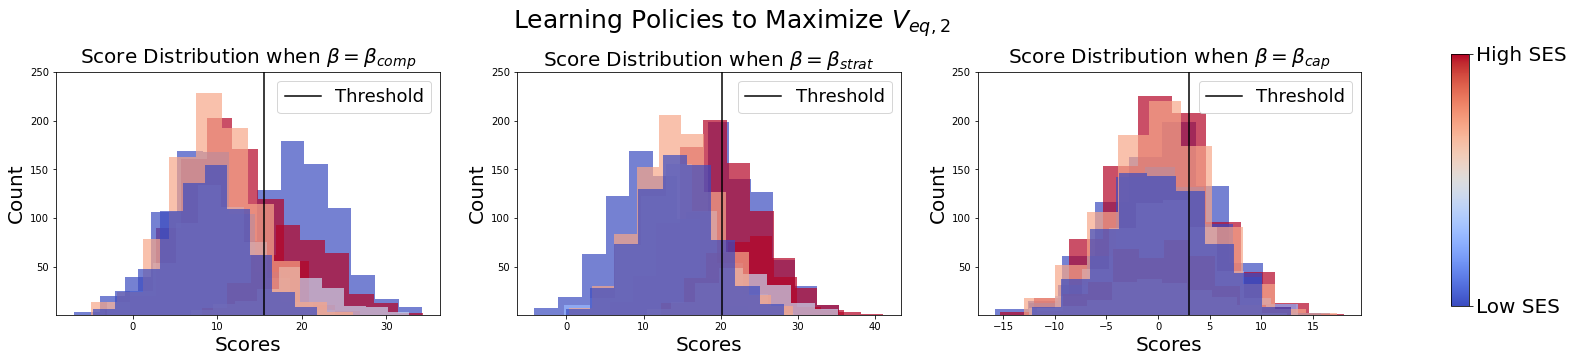

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(25, 5))
normalized_socio_econ = plot_score_dist(axs[0], agent_dist, beta_pe, sigma, q, "Score Distribution when " +r"$\beta=\beta_{comp}$")
plot_score_dist(axs[1], agent_dist, beta_me, sigma, q, "Score Distribution when " +r"$\beta=\beta_{strat}$")
normalized_socio_econ = plot_score_dist(axs[2], agent_dist, beta_naive, sigma, q, "Score Distribution when " +r"$\beta=\beta_{cap}$")

fig.subplots_adjust(right=0.85, top=0.80)
cbar_ax = fig.add_axes([0.90, 0.15, 0.01, 0.7])

norm = matplotlib.colors.Normalize(vmin=min(normalized_socio_econ), vmax=max(normalized_socio_econ))
sm = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Low SES', 'High SES'], fontsize=20)
fig.suptitle("Learning Policies to Maximize " + r"$V_{eq, 2}$", fontsize=25)
plt.savefig("figs/paper-figure-8.pdf")

        "F22XRSTD",  # READING STANDARDIZED SCORE
        "F22XMSTD",  # MATHEMATICS STANDARDIZED SCORE
        "F22XSSTD",  # SCIENCE STANDARDIZED SCORE
        "F22XHSTD",  # HISTORY/CIT/GEOG STANDARDIZED SCORE
        "F2RHENG2",  # AVERAGE GRADE IN ENGLISH (HS+B)
        "F2RHMAG2",  # AVERAGE GRADE IN MATHEMATICS (HS+B)
        "F2RHSCG2",  # AVERAGE GRADE IN SCIENCE (HS+B)
        "F2RHSOG2",  # AVERAGE GRADE IN SOCIAL STUDIES (HS+B)
        "F2RHFOG2",  # AVERAGE GRADE IN FOREIGN LANG. (HS+B)